In [1]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [4]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/processed_data.csv')
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      print(f'{filename} does not have the right shape')
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        #print(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/both"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

100%|██████████| 837/837 [00:11<00:00, 71.28it/s] 

(873, 76, 33, 3)


In [5]:
print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 76, 33, 3)
(76, 33, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.54721, saving model to model.h5
61/61 - 25s - loss: 1.8756 - accuracy: 0.4501 - val_loss: 2.5472 - val_accuracy: 0.3299 - lr: 0.0010 - 25s/epoch - 406ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.54721 to 1.83446, saving model to model.h5
61/61 - 4s - loss: 1.3254 - accuracy: 0.5778 - val_loss: 1.8345 - val_accuracy: 0.4467 - lr: 0.0010 - 4s/epoch - 59ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.83446 to 1.54619, saving model to model.h5
61/61 - 3s - loss: 1.1883 - accuracy: 0.6113 - val_loss: 1.5462 - val_accuracy: 0.5006 - lr: 0.0010 - 3s/epoch - 42ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.54619 to 1.39909, saving model to model.h5
61/61 - 3s - loss: 1.0766 - accuracy: 0.6452 - val_loss: 1.3991 - val_accuracy: 0.5269 - lr: 0.0010 - 3s/epoch - 46ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.39909 to 1.34557, saving model to model.h5
61/61 - 3s - loss: 0.9865 - a

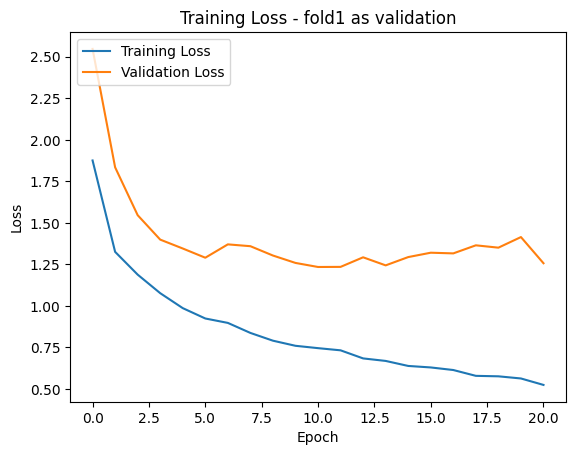

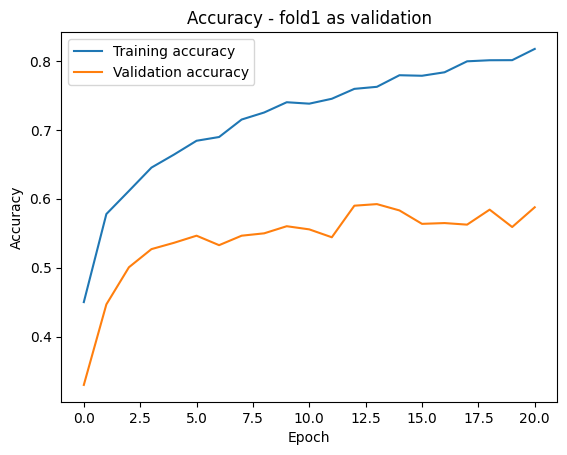

 10%|█         | 1/10 [01:46<15:58, 106.49s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.83997, saving model to model.h5
61/61 - 15s - loss: 1.8674 - accuracy: 0.4447 - val_loss: 2.8400 - val_accuracy: 0.2838 - lr: 0.0010 - 15s/epoch - 248ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.83997 to 1.64653, saving model to model.h5
61/61 - 3s - loss: 1.3400 - accuracy: 0.5675 - val_loss: 1.6465 - val_accuracy: 0.4471 - lr: 0.0010 - 3s/epoch - 57ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.64653 to 1.56492, saving model to model.h5
61/61 - 3s - loss: 1.1863 - accuracy: 0.6191 - val_loss: 1.5649 - val_accuracy: 0.4797 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.56492 to 1.38839, saving model to model.h5
61/61 - 3s - loss: 1.0945 - accuracy: 0.6344 - val_loss: 1.3884 - val_accuracy: 0.5180 - lr: 0.0010 - 3s/epoch - 45ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.38839 to 1.25958, saving model to model.h5
61/61 - 3s - loss: 1.0017 - a

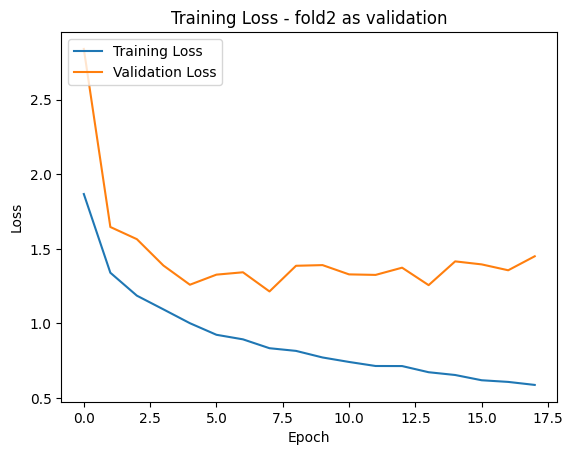

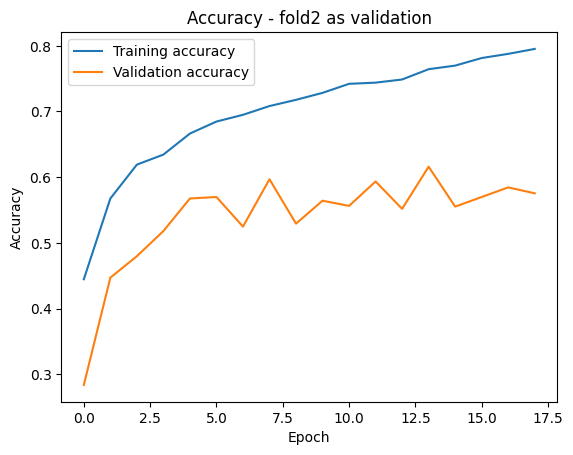

 20%|██        | 2/10 [03:27<13:47, 103.41s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.33045, saving model to model.h5
60/60 - 15s - loss: 1.8914 - accuracy: 0.4527 - val_loss: 2.3305 - val_accuracy: 0.3557 - lr: 0.0010 - 15s/epoch - 254ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.33045 to 1.78216, saving model to model.h5
60/60 - 4s - loss: 1.3240 - accuracy: 0.5864 - val_loss: 1.7822 - val_accuracy: 0.4519 - lr: 0.0010 - 4s/epoch - 71ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.78216 to 1.69332, saving model to model.h5
60/60 - 3s - loss: 1.1681 - accuracy: 0.6209 - val_loss: 1.6933 - val_accuracy: 0.4659 - lr: 0.0010 - 3s/epoch - 45ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.69332 to 1.49687, saving model to model.h5
60/60 - 3s - loss: 1.0453 - accuracy: 0.6501 - val_loss: 1.4969 - val_accuracy: 0.5168 - lr: 0.0010 - 3s/epoch - 45ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.49687
60/60 - 2s - loss: 0.9677 - accuracy: 0.6691 - val_loss: 1.

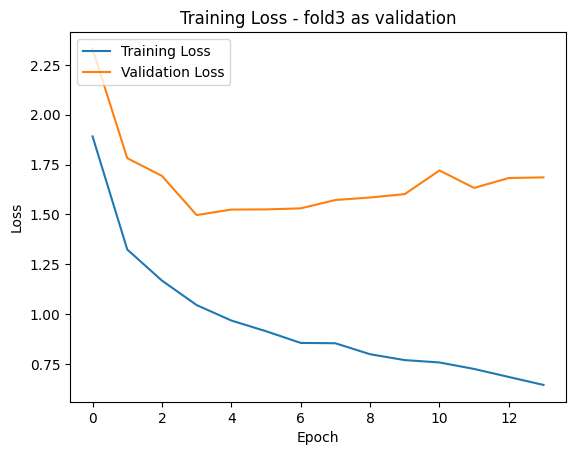

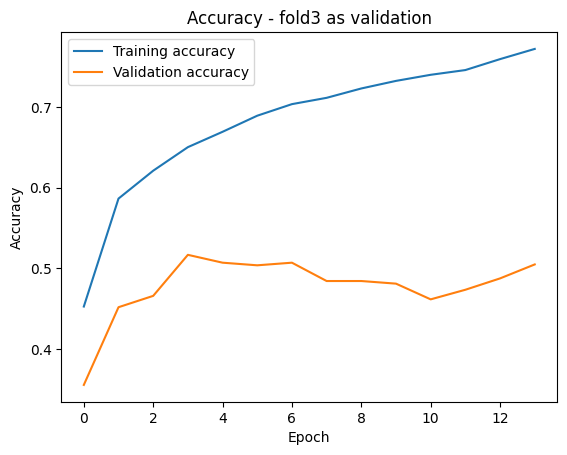

 30%|███       | 3/10 [04:26<09:42, 83.17s/it] 

Training using fold4 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.47743, saving model to model.h5
60/60 - 16s - loss: 1.8557 - accuracy: 0.4592 - val_loss: 2.4774 - val_accuracy: 0.3556 - lr: 0.0010 - 16s/epoch - 261ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.47743 to 1.92320, saving model to model.h5
60/60 - 4s - loss: 1.3333 - accuracy: 0.5779 - val_loss: 1.9232 - val_accuracy: 0.4000 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.92320 to 1.63718, saving model to model.h5
60/60 - 3s - loss: 1.1554 - accuracy: 0.6260 - val_loss: 1.6372 - val_accuracy: 0.4455 - lr: 0.0010 - 3s/epoch - 45ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.63718 to 1.57570, saving model to model.h5
60/60 - 3s - loss: 1.0705 - accuracy: 0.6506 - val_loss: 1.5757 - val_accuracy: 0.4616 - lr: 0.0010 - 3s/epoch - 44ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.57570 to 1.52210, saving model to model.h5
60/60 - 3s - loss: 0.9985 - a

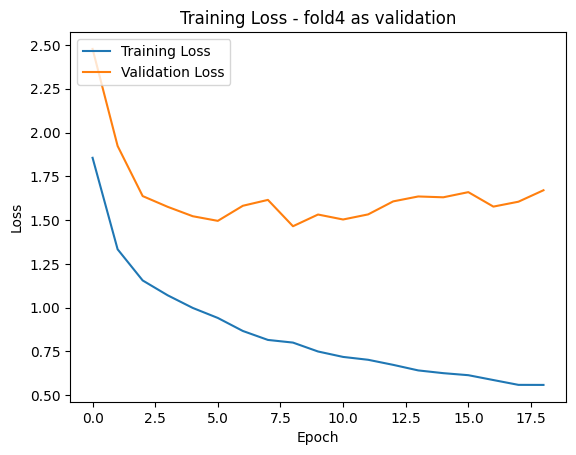

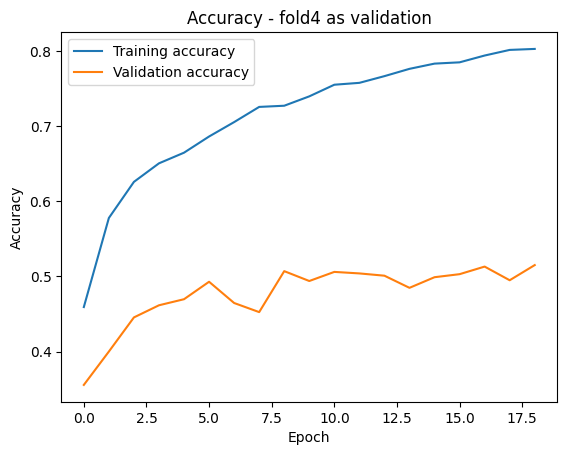

 40%|████      | 4/10 [06:08<09:01, 90.31s/it]

Training using fold5 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.11303, saving model to model.h5
60/60 - 15s - loss: 1.8302 - accuracy: 0.4643 - val_loss: 2.1130 - val_accuracy: 0.4049 - lr: 0.0010 - 15s/epoch - 251ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.11303 to 1.70560, saving model to model.h5
60/60 - 4s - loss: 1.3138 - accuracy: 0.5893 - val_loss: 1.7056 - val_accuracy: 0.4594 - lr: 0.0010 - 4s/epoch - 62ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.70560 to 1.49387, saving model to model.h5
60/60 - 3s - loss: 1.1665 - accuracy: 0.6223 - val_loss: 1.4939 - val_accuracy: 0.5171 - lr: 0.0010 - 3s/epoch - 53ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.49387 to 1.39341, saving model to model.h5
60/60 - 3s - loss: 1.0601 - accuracy: 0.6525 - val_loss: 1.3934 - val_accuracy: 0.5353 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.39341
60/60 - 2s - loss: 0.9608 - accuracy: 0.6740 - val_loss: 1.

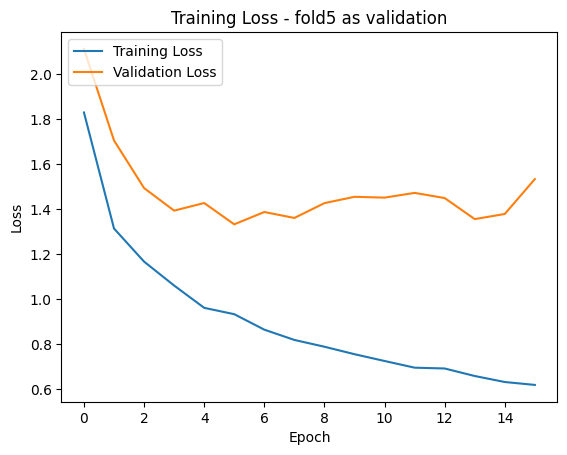

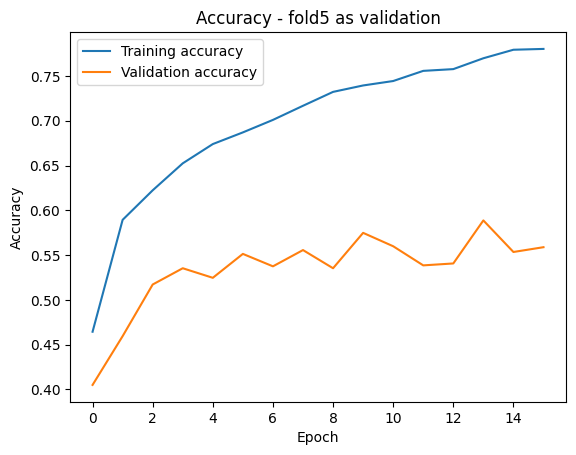

 50%|█████     | 5/10 [07:50<07:52, 94.52s/it]

Training using fold6 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.16079, saving model to model.h5
61/61 - 14s - loss: 1.8451 - accuracy: 0.4538 - val_loss: 3.1608 - val_accuracy: 0.2953 - lr: 0.0010 - 14s/epoch - 231ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.16079 to 2.15210, saving model to model.h5
61/61 - 4s - loss: 1.3115 - accuracy: 0.5815 - val_loss: 2.1521 - val_accuracy: 0.3913 - lr: 0.0010 - 4s/epoch - 60ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.15210 to 1.67160, saving model to model.h5
61/61 - 3s - loss: 1.1531 - accuracy: 0.6272 - val_loss: 1.6716 - val_accuracy: 0.5030 - lr: 0.0010 - 3s/epoch - 42ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.67160 to 1.58008, saving model to model.h5
61/61 - 3s - loss: 1.0602 - accuracy: 0.6413 - val_loss: 1.5801 - val_accuracy: 0.5128 - lr: 0.0010 - 3s/epoch - 51ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.58008 to 1.57037, saving model to model.h5
61/61 - 3s - loss: 0.9517 - a

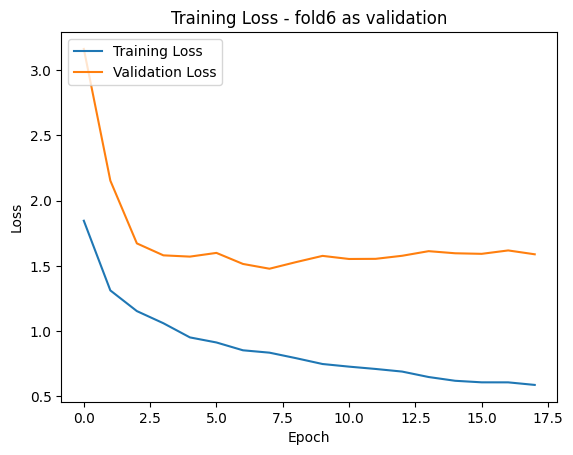

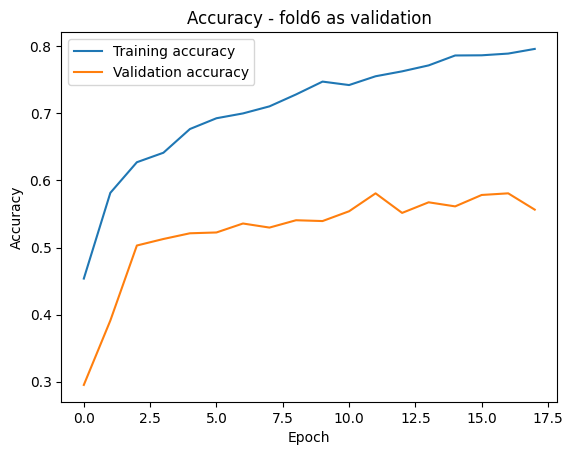

 60%|██████    | 6/10 [09:31<06:27, 96.88s/it]

Training using fold7 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.92861, saving model to model.h5
61/61 - 15s - loss: 1.8890 - accuracy: 0.4490 - val_loss: 2.9286 - val_accuracy: 0.3616 - lr: 0.0010 - 15s/epoch - 240ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.92861 to 1.89046, saving model to model.h5
61/61 - 4s - loss: 1.3493 - accuracy: 0.5636 - val_loss: 1.8905 - val_accuracy: 0.4451 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.89046 to 1.51205, saving model to model.h5
61/61 - 3s - loss: 1.1791 - accuracy: 0.6160 - val_loss: 1.5120 - val_accuracy: 0.5060 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.51205 to 1.40404, saving model to model.h5
61/61 - 3s - loss: 1.0813 - accuracy: 0.6420 - val_loss: 1.4040 - val_accuracy: 0.5334 - lr: 0.0010 - 3s/epoch - 46ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.40404 to 1.36246, saving model to model.h5
61/61 - 3s - loss: 0.9673 - a

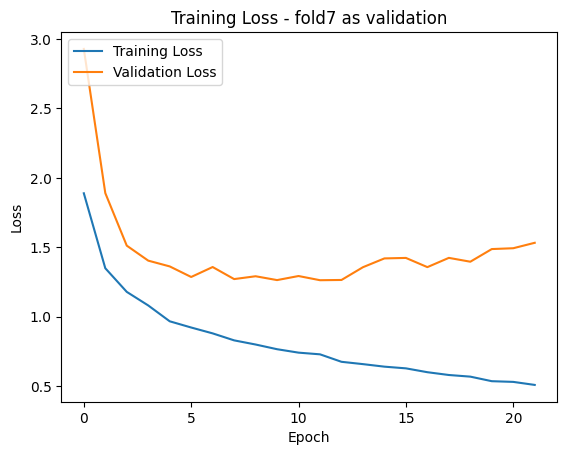

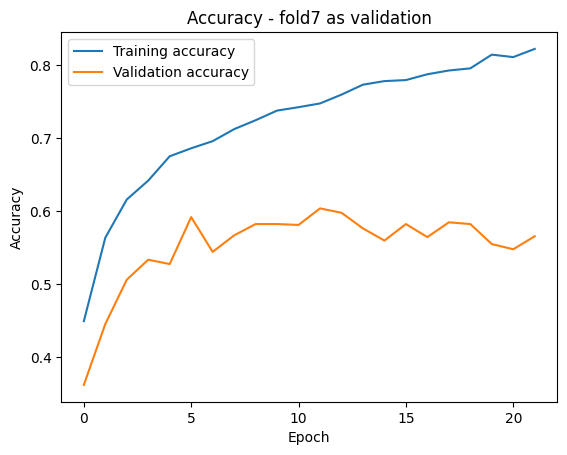

 70%|███████   | 7/10 [10:48<04:30, 90.33s/it]

Training using fold8 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.60364, saving model to model.h5
61/61 - 15s - loss: 1.8376 - accuracy: 0.4550 - val_loss: 2.6036 - val_accuracy: 0.2903 - lr: 0.0010 - 15s/epoch - 241ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.60364 to 1.76814, saving model to model.h5
61/61 - 4s - loss: 1.3000 - accuracy: 0.5859 - val_loss: 1.7681 - val_accuracy: 0.4479 - lr: 0.0010 - 4s/epoch - 62ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.76814 to 1.60436, saving model to model.h5
61/61 - 3s - loss: 1.1418 - accuracy: 0.6271 - val_loss: 1.6044 - val_accuracy: 0.4566 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.60436 to 1.52555, saving model to model.h5
61/61 - 3s - loss: 1.0339 - accuracy: 0.6552 - val_loss: 1.5255 - val_accuracy: 0.4752 - lr: 0.0010 - 3s/epoch - 48ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.52555
61/61 - 2s - loss: 0.9661 - accuracy: 0.6759 - val_loss: 1.

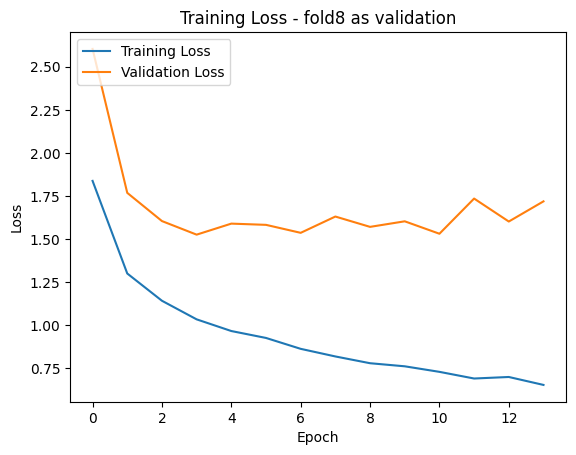

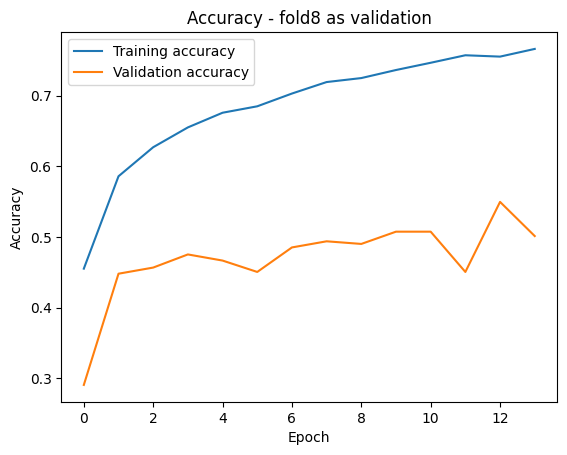

 80%|████████  | 8/10 [11:47<02:40, 80.31s/it]

Training using fold9 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.11228, saving model to model.h5
61/61 - 15s - loss: 1.9091 - accuracy: 0.4483 - val_loss: 2.1123 - val_accuracy: 0.4559 - lr: 0.0010 - 15s/epoch - 253ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.11228 to 1.60421, saving model to model.h5
61/61 - 4s - loss: 1.3416 - accuracy: 0.5751 - val_loss: 1.6042 - val_accuracy: 0.5699 - lr: 0.0010 - 4s/epoch - 67ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.60421 to 1.29363, saving model to model.h5
61/61 - 3s - loss: 1.2071 - accuracy: 0.6085 - val_loss: 1.2936 - val_accuracy: 0.6103 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.29363 to 1.12812, saving model to model.h5
61/61 - 3s - loss: 1.1038 - accuracy: 0.6397 - val_loss: 1.1281 - val_accuracy: 0.6164 - lr: 0.0010 - 3s/epoch - 42ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.12812
61/61 - 2s - loss: 0.9984 - accuracy: 0.6682 - val_loss: 1.

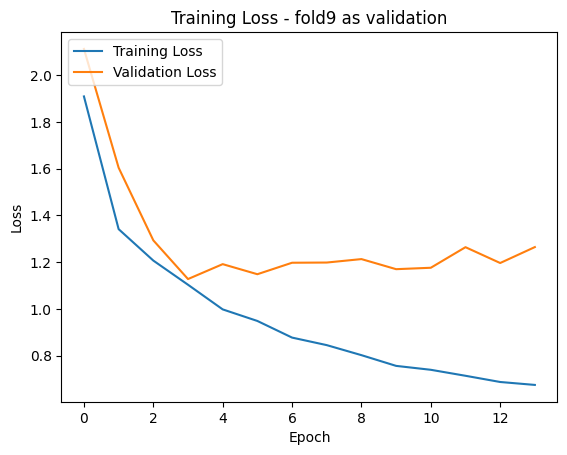

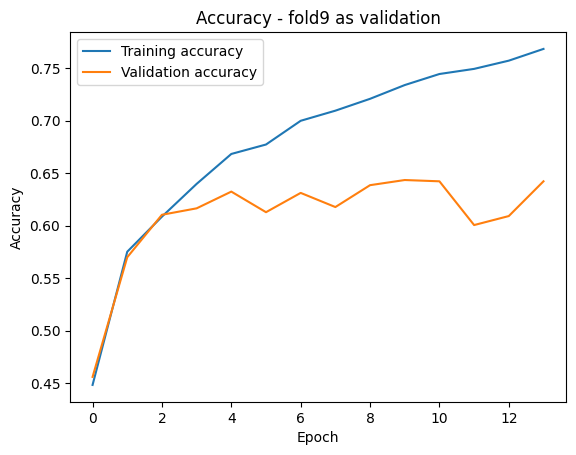

 90%|█████████ | 9/10 [12:48<01:14, 74.32s/it]

Training using fold10 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.30821, saving model to model.h5
61/61 - 15s - loss: 1.8566 - accuracy: 0.4387 - val_loss: 2.3082 - val_accuracy: 0.3967 - lr: 0.0010 - 15s/epoch - 238ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.30821 to 1.62094, saving model to model.h5
61/61 - 4s - loss: 1.3170 - accuracy: 0.5778 - val_loss: 1.6209 - val_accuracy: 0.5257 - lr: 0.0010 - 4s/epoch - 66ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.62094 to 1.38734, saving model to model.h5
61/61 - 3s - loss: 1.1509 - accuracy: 0.6261 - val_loss: 1.3873 - val_accuracy: 0.5221 - lr: 0.0010 - 3s/epoch - 44ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.38734
61/61 - 2s - loss: 1.0470 - accuracy: 0.6465 - val_loss: 1.4173 - val_accuracy: 0.5663 - lr: 0.0010 - 2s/epoch - 33ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.38734
61/61 - 2s - loss: 0.9869 - accuracy: 0.6685 - val_loss: 1.4462 - val_accuracy: 0.5496 -

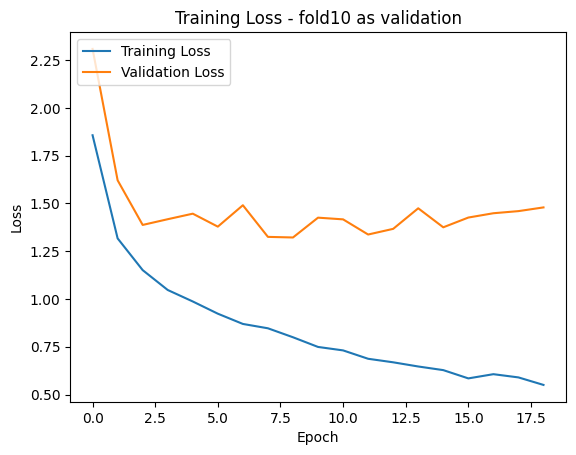

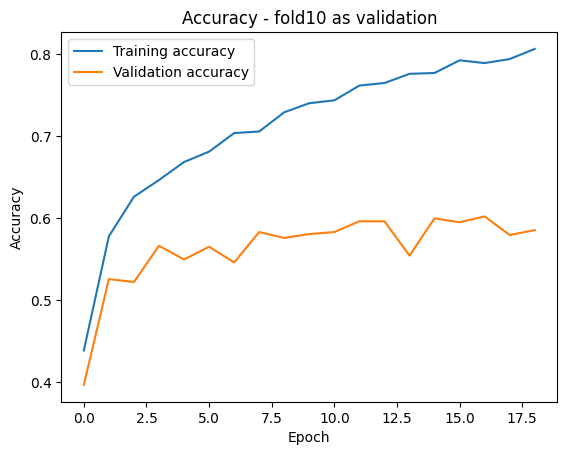

100%|██████████| 10/10 [13:56<00:00, 83.64s/it]


List of scores[0.5876288414001465, 0.5754504799842834, 0.5048648715019226, 0.5151515007019043, 0.5587607026100159, 0.5565006136894226, 0.5656324625015259, 0.5012406706809998, 0.6421568393707275, 0.5854241251945496]
Average accuracy: 0.5592811107635498
Trained only the last -8 layers
27/27 [==============================] - 4s 25ms/step
Total-test-data; 837 	accurately-predicted-data: 490 	 wrongly-predicted-data:  347
Accuracy: 58.542 %


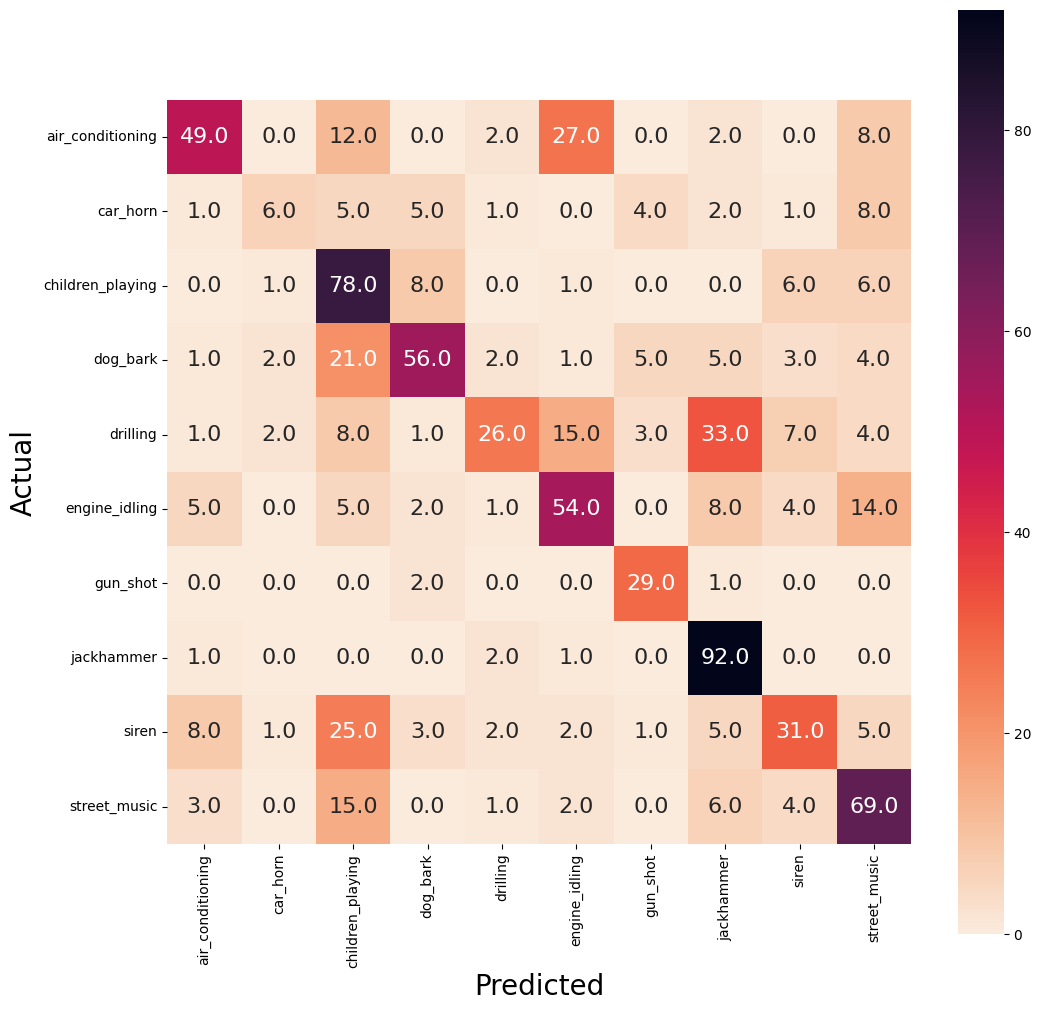

In [7]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 128
early_stop = 10 # early stoppping after 3 epochs with no improvement of test data
#trainable layers needs a minus infront
trainable_layers = -8
dropout_rate = 0.5
learning_rate = 0.001


def model_k_cross(data):
    list_scores = []
    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()

        #Densenet121 model using pretrained weights from imagenet
        model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

        x=model_d.output
        x= GlobalAveragePooling2D()(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(1024,activation='relu')(x)
        x= Dense(512,activation='relu')(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        preds=Dense(10,activation='softmax')(x) #FC-layer
        model=Model(inputs=model_d.input,outputs=preds)

        #instance of Adam optimizer
        Adam = keras.optimizers.Adam(learning_rate=learning_rate)


        #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
        for layer in model.layers[:trainable_layers]:
            layer.trainable=False
        for layer in model.layers[trainable_layers:]:
            layer.trainable=True


        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


        history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')
    print(f'Trained only the last {trainable_layers} layers')

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    Ypred = model.predict(X_val)

    for i in range(len(Ypred)):
        if np.argmax(Ypred[i]) == np.argmax(y_val[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1

    Ypred = np.argmax(Ypred, axis=1)
    Ytrue = np.argmax(y_val, axis=1)
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)


    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')


model_k_cross(data)

